In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import linearmodels as lm
import matplotlib
import math
import statsmodels.formula.api as smf
import statsmodels.api as sm

from linearmodels.panel import PanelOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import FirstDifferenceOLS
from linearmodels.panel import compare
from matplotlib import pyplot as plt

from pandas.api.types import is_numeric_dtype

pd.set_option('display.max_columns', 500)

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read the main data set
df=pd.read_csv('estimation_file_normal_fare.csv',
                    encoding='utf-8')


C:\Program Files\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (117,126) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# read in and join the maintenance and restructure data
mr=pd.read_csv('maintenance_restructure.csv',
                    encoding='utf-8')
mr = mr[['CBSA', 'Mode', 'Year', 'MAINTENANCE', 'MAINTENANCE_NYC', 'MAINTENANCE_WMATA', 'RESTRUCTURE']]

df = df.merge(mr, on=['CBSA', 'Mode', 'Year'], how='left')

In [4]:
# read in and join the bike share updates
bsu=pd.read_csv('bike_share_update.csv',
                    encoding='utf-8')
bsu = bsu[['CBSA', 'Mode', 'Year', 'PBS_Flag_Update']]

df = df.merge(bsu, on=['CBSA', 'Mode', 'Year'], how='left')

#df['PBS_Flag_Missing'] = df['PBS_Flag'].apply(lambda x : x.isnan())
df['PBS_Flag'] = np.where(df['PBS_Flag'].isnull(), df['PBS_Flag_Update'], df['PBS_Flag'])

In [5]:
# 4 apta clusers
df['CLUSTER_APTA4'] = np.floor(df['CLUSTER_APTA']/10)

In [6]:
# exclude if ridership is zero--missing data
df = df[df['UPT_ADJ']>0]

In [7]:
# exclude problematic data
old_len = len(df)
df = df[df['VRM_ADJ']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with missing VRM') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with zero or negative fare') 

# exclude problematic data
old_len = len(df)
df = df[df['FARE_per_UPT_2018']<20]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with fare greater than $20') 

# exclude problematic data
old_len = len(df)
df = df[df['HH_0Veh']>0]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' records with negative 0 veh HH') 

# drop low op-ex cluster rail
old_len = len(df)
df = df[(df['CLUSTER_APTA4']!=3) |  (df['Mode']=='Bus')]
new_len = len(df)
print('Excluding ' + str(old_len-new_len) + ' cluster 3 rail') 



Excluding 0 records with missing VRM
Excluding 74 records with zero or negative fare
Excluding 7 records with fare greater than $20
Excluding 27 records with negative 0 veh HH
Excluding 48 cluster 3 rail


In [8]:
# exclude discontinuous data
df = df.sort_values(by=['CBSA', 'Mode', 'Year'])

excluded_records = 100
while excluded_records > 0: 
    old_len = len(df)
    df['YearDiff'] = df['Year'].shift(-1) - df['Year']
    df = df[(df['YearDiff']==1) | (df['Year']==2018)]
    excluded_records = old_len - len(df)
    print('Excluding ' + str(excluded_records) + ' records with discontinuities in year.') 



Excluding 24 records with discontinuities in year.
Excluding 18 records with discontinuities in year.
Excluding 15 records with discontinuities in year.
Excluding 13 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 7 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 5 records with discontinuities in year.
Excluding 4 records with discontinuities in year.
Excluding 2 records with discontinuities in year.
Excluding 1 records with discontinuities in year.
Excluding 0 records with discontinuities in year.


In [9]:
df['BUS_FLAG'] = np.where(df['Mode']=='Bus', 1, 0)
df['RAIL_FLAG'] = np.where(df['Mode']=='Rail', 1, 0)

In [10]:
# include population + employment
df['POP_EMP'] = df['Tot_Pop'] + df['TOT_EMP_MSA']
df['HH_EMP'] = df['Total_HH'] + df['TOT_EMP_MSA']

# percent of population in transit supportive density
df['TSD_POP_PCT'] = df['POP_CENSUSTRACT'] / df['Tot_Pop']

# percent of pop born outside USA
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100


In [11]:
# mode specific effects

df['Bus_VRM_ADJ_RAIL']  = df['Bus_VRM_ADJ'] * df['RAIL_FLAG']
df['Rail_VRM_ADJ_BUS'] = df['Rail_VRM_ADJ']  * df['BUS_FLAG']

df['Bus_VRM_ADJ_RAIL_log'] = np.log(1+df['Bus_VRM_ADJ_RAIL'])
df['Rail_VRM_ADJ_BUS_log'] = np.log(1+df['Rail_VRM_ADJ_BUS'])


In [12]:
# time effects
df['YEARS_SINCE_2002']  = df['Year'] - 2002

df['YEARS_2002_2010']  = df['Year'].apply(lambda x : min(x-2002, 8))
df['YEARS_AFTER_2010'] = df['Year'].apply(lambda x : max(x-2010, 0))

df['YEARS_2002_2014']  = df['Year'].apply(lambda x : min(x-2002, 12))
df['YEARS_AFTER_2014'] = df['Year'].apply(lambda x : max(x-2014, 0))


df['YEARS_SINCE_2002_BUS']  = df['YEARS_SINCE_2002'] * df['BUS_FLAG']
df['YEARS_SINCE_2002_RAIL'] = df['YEARS_SINCE_2002'] * df['RAIL_FLAG']

df['YEARS_2002_2010_BUS']   = df['YEARS_2002_2010'] * df['BUS_FLAG']
df['YEARS_AFTER_2010_BUS']  = df['YEARS_AFTER_2010']* df['BUS_FLAG']
df['YEARS_2002_2010_RAIL']  = df['YEARS_2002_2010'] * df['RAIL_FLAG']
df['YEARS_AFTER_2010_RAIL'] = df['YEARS_AFTER_2010']* df['RAIL_FLAG']

df['YEARS_2002_2014_BUS']   = df['YEARS_2002_2014'] * df['BUS_FLAG']
df['YEARS_AFTER_2014_BUS']  = df['YEARS_AFTER_2014']* df['BUS_FLAG']
df['YEARS_2002_2014_RAIL']  = df['YEARS_2002_2014'] * df['RAIL_FLAG']
df['YEARS_AFTER_2014_RAIL'] = df['YEARS_AFTER_2014']* df['RAIL_FLAG']

In [13]:
# more time effects

df['YEARS_AFTER_2012'] = df['Year'].apply(lambda x : max(x-2012, 0))

df['TNC_YEARS_AFTER_2012'] = df['YEARS_AFTER_2012'] * df['TNC_FLAG']

df['TNC_YEARS_AFTER_2012_BUS'] = df['TNC_YEARS_AFTER_2012'] * df['BUS_FLAG']
df['TNC_YEARS_AFTER_2012_RAIL'] = df['TNC_YEARS_AFTER_2012'] * df['RAIL_FLAG']




In [14]:
# test rail ramp up period
df['YEARS_SINCE_RAIL_START'] = (df['Year'] - df['min_year']) * df['RAIL_FLAG']
df['YEARS_SINCE_RAIL_START'] = np.where(df['min_year']==2002, 0, df['YEARS_SINCE_RAIL_START'])

df['YEARS_SINCE_RAIL_START_1'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 1))
df['YEARS_SINCE_RAIL_START_2'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_RAIL_START_3'] = df['YEARS_SINCE_RAIL_START'].apply(lambda x : min(x, 3))



In [15]:
# calculate bus vs rail stuff

# various bus/rail specifics

df['TNC_FLAG_BUS'] = df['TNC_FLAG'] * df['BUS_FLAG']
df['TNC_FLAG_RAIL'] = df['TNC_FLAG'] * df['RAIL_FLAG']

df['YEARS_SINCE_TNC_BUS'] = df['YEARS_SINCE_TNC'] * df['BUS_FLAG']
df['YEARS_SINCE_TNC_RAIL'] = df['YEARS_SINCE_TNC'] * df['RAIL_FLAG']

df['dockless_flag'] = df['dockCt'].apply(lambda x : min(x,1))
df['scooter_flag']  = df['scooterCt'].apply(lambda x : min(x,1))

df['BIKE_SHARE'] = df['PBS_Flag'] + df['dockless_flag']
df['BIKE_SHARE'] = df['BIKE_SHARE'].apply(lambda x : min(x,1))


df['PBS_Flag_BUS']   = df['PBS_Flag']   * df['BUS_FLAG']
df['dockCt_BUS']     = df['dockCt']     * df['BUS_FLAG']
df['docklessCt_BUS'] = df['docklessCt'] * df['BUS_FLAG']
df['scooterCt_BUS']  = df['scooterCt']  * df['BUS_FLAG']
df['dockless_flag_BUS'] = df['dockless_flag'] * df['BUS_FLAG']
df['scooter_flag_BUS']  = df['scooter_flag']  * df['BUS_FLAG']
df['BIKE_SHARE_BUS']  = df['BIKE_SHARE']  * df['BUS_FLAG']


df['PBS_Flag_RAIL']   = df['PBS_Flag']   * df['RAIL_FLAG']
df['dockCt_RAIL']     = df['dockCt']     * df['RAIL_FLAG']
df['docklessCt_RAIL'] = df['docklessCt'] * df['RAIL_FLAG']
df['scooterCt_RAIL']  = df['scooterCt']  * df['RAIL_FLAG']
df['dockless_flag_RAIL'] = df['dockless_flag'] * df['RAIL_FLAG']
df['scooter_flag_RAIL']  = df['scooter_flag']  * df['RAIL_FLAG']
df['BIKE_SHARE_RAIL']  = df['BIKE_SHARE']  * df['RAIL_FLAG']




In [16]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('#VALUE!', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('#VALUE!', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('#VALUE!', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('#VALUE!', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('#VALUE!', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('#VALUE!', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('#VALUE!', np.nan)


df['JTW_DA_PCT']        = df['JTW_DA_PCT'].replace('N', np.nan)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].replace('N', np.nan)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].replace('N', np.nan)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].replace('N', np.nan)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].replace('N', np.nan)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].replace('N', np.nan)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].replace('N', np.nan)



In [17]:
# convert JTW to numeric columns
df['JTW_DA_PCT']        = df['JTW_DA_PCT'].astype(float)
df['JTW_CARPOOLED_PCT'] = df['JTW_CARPOOLED_PCT'].astype(float)
df['JTW_TRANSIT_PCT']   = df['JTW_TRANSIT_PCT'].astype(float)
df['JTW_WALK_PCT']      = df['JTW_WALK_PCT'].astype(float)
df['JTW_BICYCLE_PCT']   = df['JTW_BICYCLE_PCT'].astype(float)
df['JTW_OTHER_PCT']     = df['JTW_OTHER_PCT'].astype(float)
df['JTW_HOME_PCT']      = df['JTW_HOME_PCT'].astype(float)


In [18]:
# immigrant population percentage
df['Tot_NonUSA_POP_pct'] = df['Tot_NonUSA_POP'] / df['Tot_Pop'] * 100

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# include VRM on competing modes -- split
df['VRM_ADJ_COMPETING_BUS']  = df['VRM_ADJ_COMPETING'] * df['RAIL_FLAG']
df['VRM_ADJ_COMPETING_RAIL'] = df['VRM_ADJ_COMPETING'] * df['BUS_FLAG']

# flag testing introduction of new rail
df['RAIL_COMPETITION'] = np.where(df['VRM_ADJ_COMPETING']>0, 1, 0) * df['BUS_FLAG']



In [19]:
# TNC lags -- bus vs rail
df['TNC_FLAG_BUS_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['BUS_FLAG']
df['TNC_FLAG_BUS_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['BUS_FLAG']

df['TNC_FLAG_RAIL_LAGGED_1'] = df['TNC_FLAG_LAGGED_1'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_2'] = df['TNC_FLAG_LAGGED_2'] * df['RAIL_FLAG']
df['TNC_FLAG_RAIL_LAGGED_3'] = df['TNC_FLAG_LAGGED_3'] * df['RAIL_FLAG']

# bike share plus scooters for rail
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# different spec of bike and scooter
df['BIKE_SCOOTER_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] + df['scooter_flag_RAIL']

# merge bike and scooter for bus
df['BIKE_SCOOTER_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] + df['scooter_flag_BUS']

# merge bike and scooter for bus
df['BIKE_SCOOTER_BUS'] = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 

# scooter or bike
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_SHARE_BUS'] + df['scooter_flag_BUS'] 
df['BIKE_OR_SCOOTER_BUS']  = df['BIKE_OR_SCOOTER_BUS'].apply(lambda x : min(x, 1))

df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_SHARE_RAIL'] + df['scooter_flag_RAIL'] 
df['BIKE_OR_SCOOTER_RAIL'] = df['BIKE_OR_SCOOTER_RAIL'].apply(lambda x : min(x, 1))

# calculate average vehicles
df['AVG_VEHS'] = (df['HH_1Veh'] + 2*df['HH_2Veh'] + 3*df['HH_3Veh'] + 4*df['HH_4+Veh']) / (df['HH_0Veh'] + df['HH_1Veh'] + df['HH_2Veh'] + df['HH_3Veh'] + df['HH_4+Veh'])
df['AVG_VEHS_log'] = np.log(1+df['AVG_VEHS'])



In [20]:
# walk bike other commuting
df['JTW_WALK_BIKE_OTHER_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT'] + df['JTW_OTHER_PCT']

# walk bike commuting
df['JTW_WALK_BIKE_PCT'] = df['JTW_WALK_PCT'] + df['JTW_BICYCLE_PCT']


In [21]:

df['VRM_ADJ_BUS'] = df['VRM_ADJ'] * df['BUS_FLAG']
df['VRM_ADJ_RAIL'] = df['VRM_ADJ'] * df['RAIL_FLAG']

In [22]:
# percent of HH in transit supportive density
df['TSD_POP_PCT'] = df['TSD_POP_PCT'] * 100

In [23]:
# segment TNCs by cluster
df['HI_OPEX']  = np.where(df['CLUSTER_APTA4']==1, 1, 0)
df['MID_OPEX'] = np.where(df['CLUSTER_APTA4']==2, 1, 0)
df['LOW_OPEX'] = np.where(df['CLUSTER_APTA4']==3, 1, 0)
df['NEW_YORK'] = np.where(df['CLUSTER_APTA4']==10, 1, 0)

df['YEARS_SINCE_TNC_BUS_HI']  = df['YEARS_SINCE_TNC_BUS'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_BUS_MID'] = df['YEARS_SINCE_TNC_BUS'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_BUS_LOW'] = df['YEARS_SINCE_TNC_BUS'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_BUS_NY']  = df['YEARS_SINCE_TNC_BUS'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_RAIL_HI']  = df['YEARS_SINCE_TNC_RAIL'] * df['HI_OPEX']
df['YEARS_SINCE_TNC_RAIL_MID'] = df['YEARS_SINCE_TNC_RAIL'] * df['MID_OPEX']
df['YEARS_SINCE_TNC_RAIL_LOW'] = df['YEARS_SINCE_TNC_RAIL'] * df['LOW_OPEX']
df['YEARS_SINCE_TNC_RAIL_NY']  = df['YEARS_SINCE_TNC_RAIL'] * df['NEW_YORK']

df['YEARS_SINCE_TNC_BUS_HINY']  = df['YEARS_SINCE_TNC_BUS_HI'] + df['YEARS_SINCE_TNC_BUS_NY']
df['YEARS_SINCE_TNC_RAIL_HINY']  = df['YEARS_SINCE_TNC_RAIL_HI'] + df['YEARS_SINCE_TNC_RAIL_NY']

df['YEARS_SINCE_TNC_BUS_MIDLOW']  = df['YEARS_SINCE_TNC_BUS_MID'] + df['YEARS_SINCE_TNC_BUS_LOW']
df['YEARS_SINCE_TNC_RAIL_MIDLOW']  = df['YEARS_SINCE_TNC_RAIL_MID'] + df['YEARS_SINCE_TNC_RAIL_LOW']

In [24]:
# bikes and scooters by segment

df['BIKE_SHARE_HI']  = df['BIKE_SHARE'] * df['HI_OPEX']
df['BIKE_SHARE_MID'] = df['BIKE_SHARE'] * df['MID_OPEX']
df['BIKE_SHARE_LOW'] = df['BIKE_SHARE'] * df['LOW_OPEX']
df['BIKE_SHARE_NY']  = df['BIKE_SHARE'] * df['NEW_YORK']

df['scooter_flag_HI']  = df['scooter_flag'] * df['HI_OPEX']
df['scooter_flag_MID'] = df['scooter_flag'] * df['MID_OPEX']
df['scooter_flag_LOW'] = df['scooter_flag'] * df['LOW_OPEX']
df['scooter_flag_NY']  = df['scooter_flag'] * df['NEW_YORK']


df['BIKE_SHARE_HINY']  = df['BIKE_SHARE_HI'] + df['BIKE_SHARE_NY']
df['BIKE_SHARE_MIDLOW']  = df['BIKE_SHARE_MID'] + df['BIKE_SHARE_LOW']

df['scooter_flag_HINY']  = df['scooter_flag_HI'] + df['scooter_flag_NY']
df['scooter_flag_MIDLOW']  = df['scooter_flag_MID'] + df['scooter_flag_LOW']

In [25]:
# set the indices
df['ID'] = df['MNAME'] + '-' + df['Mode']
df=df.set_index(['ID','Year'])

In [26]:
# keep only the numeric columns -- the estimation will give an error otherwise
df = df.select_dtypes(include=[np.number])

In [27]:
# create a log of all fields
for col in df.columns:
    df[col+'_log'] = np.log(df[col]+1)
    

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Model Estimation Tests

In [28]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6494
Estimator:                   PanelOLS   R-squared (Between):              0.9940
No. Observations:                4011   R-squared (Within):               0.6494
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9939
Time:                        15:42:24   Log-likelihood                    1166.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      577.10
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(12,3738)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             577.10
                            

In [29]:
# High op-ex + NY
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7568
Estimator:                   PanelOLS   R-squared (Between):              0.4524
No. Observations:                 635   R-squared (Within):               0.7568
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.4538
Time:                        15:42:24   Log-likelihood                    450.51
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      151.72
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(12,585)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             151.72
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [30]:
# Mid op-ex 
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6447
Estimator:                   PanelOLS   R-squared (Between):              0.8580
No. Observations:                1270   R-squared (Within):               0.6447
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.8621
Time:                        15:42:24   Log-likelihood                    524.91
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      177.84
Entities:                          82   P-value                           0.0000
Avg Obs:                       15.488   Distribution:                 F(12,1176)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             177.84
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [31]:
# low op-ex

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6692
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                2106   R-squared (Within):               0.6692
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9967
Time:                        15:42:24   Log-likelihood                    437.80
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      359.31
Entities:                         141   P-value                           0.0000
Avg Obs:                       14.936   Distribution:                 F(11,1954)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             359.31
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## with bus vs rail VRM

In [32]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6617
Estimator:                   PanelOLS   R-squared (Between):              0.9775
No. Observations:                4011   R-squared (Within):               0.6617
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9785
Time:                        15:42:25   Log-likelihood                    1237.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.16
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.16
                            

In [33]:
# High op-ex + NY
df2 = df[(df['CLUSTER_APTA4']==1) | (df['CLUSTER_APTA4']==10)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.7596
Estimator:                   PanelOLS   R-squared (Between):              0.2869
No. Observations:                 635   R-squared (Within):               0.7596
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.2855
Time:                        15:42:25   Log-likelihood                    454.19
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      141.97
Entities:                          38   P-value                           0.0000
Avg Obs:                       16.711   Distribution:                  F(13,584)
Min Obs:                      10.0000                                           
Max Obs:                       17.000   F-statistic (robust):             141.97
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [34]:
# Mid op-ex 
df2 = df[(df['CLUSTER_APTA4']==2)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6793
Estimator:                   PanelOLS   R-squared (Between):              0.8870
No. Observations:                1270   R-squared (Within):               0.6793
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.8811
Time:                        15:42:25   Log-likelihood                    589.95
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      191.45
Entities:                          82   P-value                           0.0000
Avg Obs:                       15.488   Distribution:                 F(13,1175)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             191.45
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [35]:
# low op-ex

df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6692
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                2106   R-squared (Within):               0.6692
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9967
Time:                        15:42:26   Log-likelihood                    437.80
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      359.31
Entities:                         141   P-value                           0.0000
Avg Obs:                       14.936   Distribution:                 F(11,1954)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             359.31
                            

## Treat just low as its own grouping

In [36]:
# High op-ex + Mid op-ex + NY
df2 = df[(df['CLUSTER_APTA4']!=3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6745
Estimator:                   PanelOLS   R-squared (Between):              0.9837
No. Observations:                1905   R-squared (Within):               0.6745
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9833
Time:                        15:42:26   Log-likelihood                    933.80
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      282.48
Entities:                         120   P-value                           0.0000
Avg Obs:                       15.875   Distribution:                 F(13,1772)
Min Obs:                       4.0000                                           
Max Obs:                       17.000   F-statistic (robust):             282.48
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


In [37]:
# Low op-ex
df2 = df[(df['CLUSTER_APTA4']==3)]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6692
Estimator:                   PanelOLS   R-squared (Between):              0.9969
No. Observations:                2106   R-squared (Within):               0.6692
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9967
Time:                        15:42:26   Log-likelihood                    437.80
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      359.31
Entities:                         141   P-value                           0.0000
Avg Obs:                       14.936   Distribution:                 F(11,1954)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             359.31
                            

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


## Partial Segmentation -- low vs others

In [38]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + BIKE_SHARE_LOW \
                    + scooter_flag \
                    + scooter_flag_LOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6624
Estimator:                   PanelOLS   R-squared (Between):              0.9800
No. Observations:                4011   R-squared (Within):               0.6624
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9809
Time:                        15:42:27   Log-likelihood                    1241.8
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      457.90
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(16,3734)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             457.90
                            

In [39]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + BIKE_SHARE_LOW \
                    + scooter_flag \
                    + scooter_flag_LOW \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6503
Estimator:                   PanelOLS   R-squared (Between):              0.9957
No. Observations:                4011   R-squared (Within):               0.6503
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9956
Time:                        15:42:28   Log-likelihood                    1171.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      462.99
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(15,3735)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             462.99
                            

## look again at rail expansion

In [40]:
# rail expansion--nope

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + RAIL_COMPETITION \
                    + YEARS_SINCE_RAIL_START_2 \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6498
Estimator:                   PanelOLS   R-squared (Between):              0.9941
No. Observations:                4011   R-squared (Within):               0.6498
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9940
Time:                        15:42:29   Log-likelihood                    1168.2
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      495.09
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(14,3736)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             495.09
                            

## Look at years since TNC segmentation again

In [41]:
# Final Model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_NY \
                    + YEARS_SINCE_TNC_RAIL_HI \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6638
Estimator:                   PanelOLS   R-squared (Between):              0.9824
No. Observations:                4011   R-squared (Within):               0.6638
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9832
Time:                        15:42:30   Log-likelihood                    1250.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      409.43
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(18,3732)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             409.43
                            

In [42]:
# merge rail

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6627
Estimator:                   PanelOLS   R-squared (Between):              0.9809
No. Observations:                4011   R-squared (Within):               0.6627
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9818
Time:                        15:42:30   Log-likelihood                    1243.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      458.54
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(16,3734)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             458.54
                            

In [43]:
# merge mid/low

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6627
Estimator:                   PanelOLS   R-squared (Between):              0.9807
No. Observations:                4011   R-squared (Within):               0.6627
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9816
Time:                        15:42:31   Log-likelihood                    1243.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      489.17
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(15,3735)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             489.17
                            

In [44]:
# merge NY and high

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6627
Estimator:                   PanelOLS   R-squared (Between):              0.9808
No. Observations:                4011   R-squared (Within):               0.6627
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9817
Time:                        15:42:31   Log-likelihood                    1243.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      524.24
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(14,3736)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             524.24
                            

## more TNC specifications

In [45]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6617
Estimator:                   PanelOLS   R-squared (Between):              0.9775
No. Observations:                4011   R-squared (Within):               0.6617
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9785
Time:                        15:42:33   Log-likelihood                    1237.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.16
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.16
                            

In [46]:
# flags

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6569
Estimator:                   PanelOLS   R-squared (Between):              0.9732
No. Observations:                4011   R-squared (Within):               0.6569
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9743
Time:                        15:42:34   Log-likelihood                    1209.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      550.45
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             550.45
                            

In [47]:
# LAGGED TNC EFFECT

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_FLAG_BUS \
                    + TNC_FLAG_BUS_LAGGED_1 \
                    + TNC_FLAG_BUS_LAGGED_2 \
                    + TNC_FLAG_BUS_LAGGED_3 \
                    + TNC_FLAG_RAIL \
                    + TNC_FLAG_RAIL_LAGGED_1 \
                    + TNC_FLAG_RAIL_LAGGED_2 \
                    + TNC_FLAG_RAIL_LAGGED_3 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6606
Estimator:                   PanelOLS   R-squared (Between):              0.9766
No. Observations:                4011   R-squared (Within):               0.6606
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9776
Time:                        15:42:34   Log-likelihood                    1231.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      382.25
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(19,3731)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             382.25
                            

In [48]:
# Test TNC ramp up

df['YEARS_SINCE_TNC_BUS_2'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_BUS_3'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_BUS_4'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_BUS_5'] = df['YEARS_SINCE_TNC_BUS'].apply(lambda x : min(x, 5))

df['YEARS_SINCE_TNC_RAIL_2'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 2))
df['YEARS_SINCE_TNC_RAIL_3'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 3))
df['YEARS_SINCE_TNC_RAIL_4'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 4))
df['YEARS_SINCE_TNC_RAIL_5'] = df['YEARS_SINCE_TNC_RAIL'].apply(lambda x : min(x, 5))

In [49]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_2 \
                    + YEARS_SINCE_TNC_RAIL_2 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6599
Estimator:                   PanelOLS   R-squared (Between):              0.9775
No. Observations:                4011   R-squared (Within):               0.6599
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9785
Time:                        15:42:39   Log-likelihood                    1227.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      557.79
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             557.79
                            

In [50]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_3 \
                    + YEARS_SINCE_TNC_RAIL_3 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6611
Estimator:                   PanelOLS   R-squared (Between):              0.9786
No. Observations:                4011   R-squared (Within):               0.6611
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9795
Time:                        15:42:39   Log-likelihood                    1234.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      560.75
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             560.75
                            

In [51]:
# TNC RAMP UP


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_4 \
                    + YEARS_SINCE_TNC_RAIL_4 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6618
Estimator:                   PanelOLS   R-squared (Between):              0.9788
No. Observations:                4011   R-squared (Within):               0.6618
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9798
Time:                        15:42:40   Log-likelihood                    1238.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.51
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.51
                            

In [52]:
# TNC RAMP UP
# this is about the same as years since TNC

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_5 \
                    + YEARS_SINCE_TNC_RAIL_5 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)



C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6618
Estimator:                   PanelOLS   R-squared (Between):              0.9781
No. Observations:                4011   R-squared (Within):               0.6618
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9791
Time:                        15:42:41   Log-likelihood                    1238.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.63
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.63
                            

In [53]:
# TNC years since 2012

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_YEARS_AFTER_2012_BUS \
                    + TNC_YEARS_AFTER_2012_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6602
Estimator:                   PanelOLS   R-squared (Between):              0.9828
No. Observations:                4011   R-squared (Within):               0.6602
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9836
Time:                        15:42:43   Log-likelihood                    1228.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      558.57
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             558.57
                            

In [54]:
# BOTH

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + TNC_YEARS_AFTER_2012_BUS \
                    + TNC_YEARS_AFTER_2012_RAIL \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)


C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6638
Estimator:                   PanelOLS   R-squared (Between):              0.9845
No. Observations:                4011   R-squared (Within):               0.6638
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9852
Time:                        15:42:45   Log-likelihood                    1250.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      491.74
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(15,3735)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             491.74
                            

In [55]:
# count the first year of TNC presence
df['YEARS_SINCE_TNC_BUS2'] = df['YEARS_SINCE_TNC_BUS'] + df['TNC_FLAG_BUS']
df['YEARS_SINCE_TNC_RAIL2'] = df['YEARS_SINCE_TNC_RAIL'] + df['TNC_FLAG_RAIL']


mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS2 \
                    + YEARS_SINCE_TNC_RAIL2 \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6613
Estimator:                   PanelOLS   R-squared (Between):              0.9787
No. Observations:                4011   R-squared (Within):               0.6613
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9797
Time:                        15:42:46   Log-likelihood                    1235.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      561.19
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             561.19
                            

In [56]:
# MAINTENANCE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + MAINTENANCE \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6619
Estimator:                   PanelOLS   R-squared (Between):              0.9771
No. Observations:                4011   R-squared (Within):               0.6619
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9781
Time:                        15:42:47   Log-likelihood                    1238.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      522.33
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(14,3736)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             522.33
                            

## model without new york



In [57]:
# base model

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6617
Estimator:                   PanelOLS   R-squared (Between):              0.9775
No. Observations:                4011   R-squared (Within):               0.6617
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9785
Time:                        15:42:49   Log-likelihood                    1237.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      562.16
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(13,3737)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             562.16
                            

In [58]:
# excluding NY

df2 = df[df['NEW_YORK']==0]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6619
Estimator:                   PanelOLS   R-squared (Between):              0.9798
No. Observations:                3977   R-squared (Within):               0.6619
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9808
Time:                        15:42:50   Log-likelihood                    1213.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      558.06
Entities:                         259   P-value                           0.0000
Avg Obs:                       15.355   Distribution:                 F(13,3705)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             558.06
                            

In [59]:
# excluding NY

df2 = df[df['NEW_YORK']==0]

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_BUS \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df2)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6620
Estimator:                   PanelOLS   R-squared (Between):              0.9799
No. Observations:                3977   R-squared (Within):               0.6620
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9808
Time:                        15:42:50   Log-likelihood                    1213.9
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      483.47
Entities:                         259   P-value                           0.0000
Avg Obs:                       15.355   Distribution:                 F(15,3703)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             483.47
                            

## Segmentation

In [60]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_NY \
                    + YEARS_SINCE_TNC_BUS_HI \
                    + YEARS_SINCE_TNC_BUS_MID \
                    + YEARS_SINCE_TNC_BUS_LOW \
                    + YEARS_SINCE_TNC_RAIL_NY \
                    + YEARS_SINCE_TNC_RAIL_HI \
                    + YEARS_SINCE_TNC_RAIL_MID \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6638
Estimator:                   PanelOLS   R-squared (Between):              0.9824
No. Observations:                4011   R-squared (Within):               0.6638
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9832
Time:                        15:42:52   Log-likelihood                    1250.4
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      409.43
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(18,3732)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             409.43
                            

In [61]:
# TNC segmentation

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS_HINY \
                    + YEARS_SINCE_TNC_BUS_MIDLOW \
                    + YEARS_SINCE_TNC_RAIL_HINY \
                    + YEARS_SINCE_TNC_RAIL_MIDLOW \
                    + BIKE_SHARE \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6637
Estimator:                   PanelOLS   R-squared (Between):              0.9817
No. Observations:                4011   R-squared (Within):               0.6637
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9826
Time:                        15:42:52   Log-likelihood                    1249.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      491.43
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(15,3735)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             491.43
                            

In [62]:
# model 6.4 specification  

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + YEARS_SINCE_TNC_RAIL \
                    + BIKE_SHARE_BUS \
                    + scooter_flag_BUS \
                    + BIKE_SHARE_RAIL \
                    + scooter_flag_RAIL \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6497
Estimator:                   PanelOLS   R-squared (Between):              0.9940
No. Observations:                4011   R-squared (Within):               0.6497
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9939
Time:                        15:42:53   Log-likelihood                    1167.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      494.92
Entities:                         261   P-value                           0.0000
Avg Obs:                       15.368   Distribution:                 F(14,3736)
Min Obs:                       3.0000                                           
Max Obs:                       17.000   F-statistic (robust):             494.92
                            

## Run some analytics

In [64]:
# Final Model -- EXCLUDE TNC RAIL AND BIKE SHARE

mod=PanelOLS.from_formula('UPT_ADJ_log \
                    ~ VRM_ADJ_BUS_log \
                    + VRM_ADJ_RAIL_log \
                    + FARE_per_UPT_2018_log \
                    + POP_EMP_log \
                    + GAS_PRICE_2018_log \
                    + TOTAL_MED_INC_INDIV_2018_log \
                    + PCT_HH_NO_VEH \
                    + TSD_POP_PCT \
                    + JTW_HOME_PCT \
                    + YEARS_SINCE_TNC_BUS \
                    + scooter_flag \
                    + EntityEffects \
                    ',data=df)
res=mod.fit()
print(res)

C:\Program Files\Anaconda3\lib\site-packages\linearmodels\panel\data.py:39: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  new_df = df.copy().loc[self._full_index]
C:\Program Files\Anaconda3\lib\site-packages\linearmodels\utility.py:476: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


                          PanelOLS Estimation Summary                           
Dep. Variable:            UPT_ADJ_log   R-squared:                        0.6562
Estimator:                   PanelOLS   R-squared (Between):              0.9773
No. Observations:                3746   R-squared (Within):               0.6562
Date:                Tue, Dec 17 2019   R-squared (Overall):              0.9788
Time:                        14:58:00   Log-likelihood                    2054.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      604.33
Entities:                         252   P-value                           0.0000
Avg Obs:                       14.865   Distribution:                 F(11,3483)
Min Obs:                       1.0000                                           
Max Obs:                       17.000   F-statistic (robust):             604.33
                            

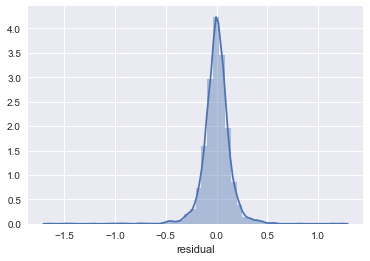

In [65]:
sns.distplot(res.resids)

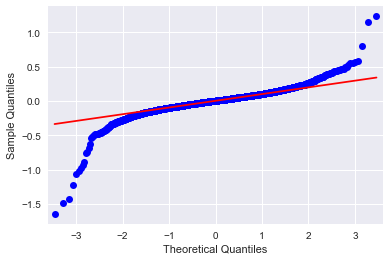

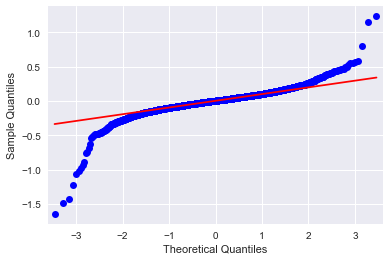

In [66]:
sm.graphics.qqplot(res.resids,line = 'q')

## Calculate FAC

In [67]:
# keep the relevant fields in the data set
app_data = pd.concat([df[['RAIL_FLAG', 'CLUSTER_APTA']], 
                      res.model.dependent.dataframe, 
                      res.model.exog.dataframe, 
                      res.estimated_effects, 
                      res.resids], axis=1)


In [68]:
app_data.head()

RAIL_FLAG  CLUSTER_APTA  UPT_ADJ_log  \
Akron, OH Metro Area-Bus 2002          0            24    15.469231   
                         2003          0            24    15.501150   
                         2004          0            24    15.591676   
                         2005          0            24    15.609548   
                         2006          0            24    15.619001   

                               VRM_ADJ_BUS_log  VRM_ADJ_RAIL_log  \
Akron, OH Metro Area-Bus 2002        15.208377               0.0   
                         2003        15.195930               0.0   
                         2004        15.277699               0.0   
                         2005        15.214971               0.0   
                         2006        15.200501               0.0   

                               FARE_per_UPT_2018_log  POP_EMP_log  \
Akron, OH Metro Area-Bus 2002               0.148254    13.808216   
                         2003               0.462904    13.823451   
                         2004               0.414204    13.839439   
                         2005               0.460804    13.857195   
                         2006               0.462420    13.879496   

                               GAS_PRICE_2018_log  \
Akron, OH Metro Area-Bus 2002            1.066089   
                         2003            1.138954   
                         2004            1.233697   
                         2005            1.361617   
                         2006            1.429114   

                               TOTAL_MED_INC_INDIV_2018_log  PCT_HH_NO_VEH  \
Akron, OH Metro Area-Bus 2002                     10.479210           8.60   
                         2003                     10.446267           8.20   
                         2004                     10.403980           7.79   
                         2005                     10.365663           7.47   
                         2006                     10.305856           6.85   

                               TSD_POP_PCT  JTW_HOME_PCT  YEARS_SINCE_TNC_BUS  \
Akron, OH Metro Area-Bus 2002    18.525984           3.1                  0.0   
                         2003    18.076969           3.1                  0.0   
                         2004    17.637662           3.1                  0.0   
                         2005    17.243546           3.1                  0.0   
                         2006    16.754287           2.5                  0.0   

                               scooter_flag   effects  residual  
Akron, OH Metro Area-Bus 2002           0.0  0.237028 -0.133159  
                         2003           0.0  0.237028 -0.002739  
                         2004           0.0  0.237028 -0.031946  
                         2005           0.0  0.237028  0.018335  
                         2006           0.0  0.237028  0.002517

In [69]:
# calculate the fitted values
app_data['fitted'] = app_data['effects']
for var in res.params.keys(): 
    app_data['fitted'] = app_data['fitted'] + (res.params[var] * app_data[var])

# and check that we add up correctly
app_data['check_fitted'] = app_data['fitted'] + app_data['residual'] - app_data['UPT_ADJ_log']

In [70]:
# create the necessary columns

# dependents
app_data['UPT_ADJ']    = np.exp(app_data['UPT_ADJ_log']) - 1
app_data['fitted_exp'] = np.exp(app_data['fitted']) - 1

# linear versions of logged variables
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '')] = np.exp(app_data[var]) - 1              

# ratios and differences
for var in res.params.keys(): 
    if '_log' in var: 
        app_data[var.replace('_log', '_ratio')] = 1
    else: 
        app_data[var+'_diff'] = 0

# FAC multipliers
for var in res.params.keys(): 
    app_data[var+'_FAC_ratio'] = 1

app_data['UPT_ADJ_base'] = 0
app_data['UPT_ADJ_ratio'] = 1
app_data['fitted_exp_ratio'] = 1
app_data['UPT_ADJ_diff'] = 0
app_data['fitted_exp_diff'] = 0

# for tracking new systems
app_data['UPT_ADJ_first_year'] = 0
app_data['UPT_ADJ_new_reporter'] = 0


In [71]:
# get the ridership in the first year the system starts. This allows us to track new systems. 
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()
    first_year = years[0]

    app_data.loc[(id,first_year),'UPT_ADJ_new_reporter'] = app_data.loc[(id,first_year),'UPT_ADJ']
    
    for year in years: 
        app_data.loc[(id,year),'UPT_ADJ_first_year']   = app_data.loc[(id,first_year),'UPT_ADJ']


In [72]:
# calculate the FAC relative to a specific base year
ids = app_data.index.get_level_values(0).unique()

for id in ids: 
    years = app_data.loc[id].index.get_level_values(0).sort_values()

    for year in years[1:]:       
        base_year = year-1
        
        for var in res.params.keys(): 
            # ratios and differences
            if '_log' in var: 
                out_var = var.replace('_log', '_ratio')
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 / app_data.loc[(id,base_year), var])
            else: 
                out_var = var+'_diff'                    
                app_data.loc[(id,year), out_var] = (app_data.loc[(id,year), var] 
                                                 - app_data.loc[(id,base_year), var])

            # FAC multipliers
            app_data.loc[(id,year),var+'_FAC_ratio'] = np.exp(res.params[var] * (
                                                    app_data.loc[(id,year), var] 
                                                    - app_data.loc[(id,base_year), var]))

            # estimated effects (if time effects is zero, no change)
            app_data.loc[(id,year),'effects_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'effects'] 
                                                    - app_data.loc[(id,base_year), 'effects'])

            # residual
            app_data.loc[(id,year),'residual_FAC_ratio'] = np.exp(
                                                    app_data.loc[(id,year), 'residual'] 
                                                    - app_data.loc[(id,base_year), 'residual'])

        # observed and fitted changes            
        app_data.loc[(id,year),'UPT_ADJ_base'] = app_data.loc[(id,base_year),'UPT_ADJ']
        app_data.loc[(id,year),'UPT_ADJ_ratio'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 / app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_ratio'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 / app_data.loc[(id,base_year),'fitted_exp'])

        app_data.loc[(id,year),'UPT_ADJ_diff'] = (app_data.loc[(id,year),'UPT_ADJ'] 
                                                 - app_data.loc[(id,base_year),'UPT_ADJ'])
        app_data.loc[(id,year),'fitted_exp_diff'] = (app_data.loc[(id,year),'fitted_exp'] 
                                                 - app_data.loc[(id,base_year),'fitted_exp'])
        

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning: invalid value encountered in double_scalars


In [73]:
# calculate the FAC
app_data['FAC_Sum'] = 0
for var in res.params.keys(): 
    app_data[var+'_FAC'] = (app_data[var+'_FAC_ratio'] - 1) * app_data['UPT_ADJ_base']
    app_data['FAC_Sum'] = app_data['FAC_Sum'] + app_data[var+'_FAC']


In [74]:

# total FAC is based on the fitted model (applied multiplicitively)
app_data['Known_FAC'] = (app_data['fitted_exp_ratio'] - 1) * app_data['UPT_ADJ_base']

# uknown change is the difference between the observed change and the known change
app_data['Unknown_FAC'] = app_data['UPT_ADJ_diff'] - app_data['Known_FAC']

# the change in ridership associated new systems
app_data['New_Reporter_FAC'] = app_data['UPT_ADJ_new_reporter'] 

# should be teh same as UPT_ADJ_DIFF
app_data['Total_Change'] = app_data['Known_FAC'] + app_data['Unknown_FAC'] + app_data['New_Reporter_FAC']


In [75]:
# calculate APTA - 4 groups
app_data['CLUSTER_APTA4'] = np.floor(app_data['CLUSTER_APTA']/10)

In [76]:
# reset the index so I get ID and year
app_data = app_data.reset_index()
app_data = app_data.rename(columns={'level_0' : 'ID', 'level_1' : 'Year'})
app_data.to_csv('FAC.csv')

In [81]:
# these are the fields we keep
out_fields = ['ID', 'Year', 'RAIL_FLAG', 
              'CLUSTER_APTA', 'CLUSTER_APTA4',    
              'UPT_ADJ_first_year', 
              'UPT_ADJ_base', 'UPT_ADJ', 'UPT_ADJ_diff', 
              'fitted_exp', 'fitted_exp_diff']

# exogenous variables 
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    out_fields = out_fields + [out_var]
    
# FAC
for var in res.params.keys(): 
    out_fields = out_fields + [var+'_FAC']
out_fields = out_fields + ['FAC_Sum', 'Known_FAC', 'Unknown_FAC', 'New_Reporter_FAC', 'Total_Change']
    
# keep those fields
summary_data = app_data.reset_index()[out_fields]

In [82]:
# take weighted average of exogenous variables
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data[out_var] = summary_data[out_var] * summary_data['UPT_ADJ_first_year']

# aggregate to bus/rail totals
summary_data_apta4 = summary_data.groupby(by=['CLUSTER_APTA4', 'RAIL_FLAG', 'Year']).agg('sum')

# divide for weighted averages
for var in res.params.keys(): 
    out_var = var.replace('_log', '')
    summary_data_apta4[out_var] = summary_data_apta4[out_var] / summary_data_apta4['UPT_ADJ_first_year']
    

In [83]:

summary_data_apta4.to_csv('FAC_totals_APTA4_CLUSTERS.csv')
